In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import math
from sklearn.preprocessing import StandardScaler
import random
import sklearn
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [2]:
cocomo=pd.read_csv("C:\\Users\\Asus\\Desktop\\Tehran university\\Seminar\\Datasets\\cocomo81_dataset.csv",header=None)
columns_cocomo=['rely','data','cplx','time','stor','virt','turn','acap','aexp','pcap','vexp','lexp','modp','tool','sced','loc','actual']
cocomo.set_axis(columns_cocomo,axis='columns',inplace=True)
cocomo.set_axis(range(1,64),axis=0 ,inplace=True)
cocomo.rename_axis("Features", axis=1,inplace=True)
cocomo.rename_axis("Projects", axis=0,inplace=True)

X = cocomo.drop('actual',axis=1).values
# Target values y should have shape (n_samples,)
y = cocomo['actual'].values

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Split data into train and test sets


# Create a classifier
estimator = SVR(kernel="linear")

# Create SFS model
sfs = SequentialFeatureSelector(estimator, n_features_to_select='auto', direction='forward', cv=5 , scoring='neg_mean_absolute_error',tol=1)

# Fit SFS model on training data
sfs.fit(X, y)

# Transform the data to selected features
X_selected = sfs.transform(X)


#=====================================================================================================================

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_selected)


pbounds = {'C': (0.1, 10),
           'epsilon': (0.01, 1),
           'gamma': (0.01, 100),
           'kernel': (0, 3)  # Use indices for categorical parameter
}
kernel_mapping = {0: 'linear', 1: 'rbf', 2: 'poly', 3: 'sigmoid'}

def svr_model(kernel,C, epsilon, gamma):
    model = SVR( kernel = kernel_mapping[int(kernel)], C=C, epsilon=epsilon, gamma=gamma)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return -rmse  # Minimize the negative RMSE for Bayesian optimization.
    
    
# Perform Bayesian optimization with k-fold cross-validation.
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed_value)
mean_RMSE=[]
mean_MMRE=[]
mean_MAE=[]

for train_index, val_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[val_index]
    y_train, y_test = y[train_index], y[val_index]
    
    optimizer = BayesianOptimization(
        f=svr_model,
        pbounds=pbounds,
        random_state=42,
        verbose=0,
    )
    
    optimizer.maximize(init_points=10, n_iter=30)  # Adjust the number of initial points and iterations.
    
    best_params = optimizer.max['params']
    best_C = best_params['C']
    best_epsilon = best_params['epsilon']
    best_gamma = best_params['gamma']
    best_kernel = kernel_mapping[int(best_params['kernel'])]
    
    final_model = SVR(C=best_C, epsilon=best_epsilon, gamma=best_gamma, kernel=best_kernel)
    final_model.fit(X_train, y_train)
    
    y_pred = final_model.predict(X_test)
  
    mae = mean_absolute_error(y_test, y_pred)
    mean_MAE.append(mae)

    # Calculate Mean Magnitude of Relative Error (MMRE)
    mmre = np.mean(np.abs((y_test - y_pred) / y_test))
    mean_MMRE.append(mmre)

    # Calculate the Root Mean Squared Error (RMSE) to assess the model's performance.
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mean_RMSE.append(rmse)
    
print(f"Mean Absolute Error mean: {np.mean(mean_MAE)}")   
print(f"Mean Magnitude of Relative Error mean (MMRE): {np.mean(mean_MMRE):.2f}")
print(f"Root Mean Squared Error (RMSE) mean: {np.mean(mean_RMSE)}")

Mean Absolute Error mean: 579.828303467333
Mean Magnitude of Relative Error mean (MMRE): 1.89
Root Mean Squared Error (RMSE) mean: 1307.3815283945773


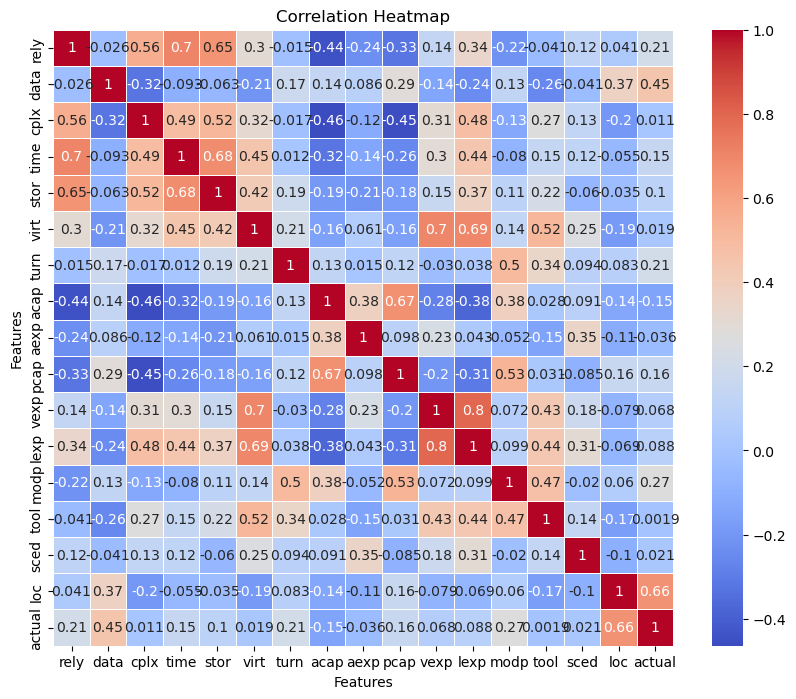

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_data.csv' with your actual data file)


# Make sure your DataFrame is in the right format
# Example: data = data[['Feature1', 'Feature2', 'Effort']]

# Calculate correlation matrix
correlation_matrix = cocomo.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()
